In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
import keras.backend as K
from sklearn.model_selection import train_test_split

K.clear_session()
IMG_HEIGHT, IMG_WIDTH = 768, 768
train_masks_data = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

train_masks_data[:10]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [2]:
train_masks_data['EncodedPixels'] = train_masks_data['EncodedPixels'].astype(str)
train_masks_data['EncodedPixels'] = train_masks_data['EncodedPixels'].fillna('')
train_masks_data['EncodedPixels'] = train_masks_data['EncodedPixels'].replace('nan', '')

train_masks_data = train_masks_data.groupby('ImageId')['EncodedPixels'].agg(lambda i: ' '.join(i)).reset_index()

In [3]:
train_masks_data[:10]

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
7,0002d0f32.jpg,
8,000303d4d.jpg,
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...


In [4]:
def convert_mask_data(data):
    empty_mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,3), np.uint8)
    local_mask_data = [int(i) for i in data.split()]

    for i in range(0, len(local_mask_data) - 1, 2):
        line = round(local_mask_data[i] / IMG_WIDTH)
        col_start = local_mask_data[i] - (line * IMG_WIDTH)
        col_end = col_start + local_mask_data[i + 1]
        empty_mask[col_start : col_start + local_mask_data[i + 1] + 1, line - 1, :] = 255

    return empty_mask

In [5]:
folder = '/kaggle/input/airbus-ship-detection/train_v2/'
img_list = []

for filename in sorted(os.listdir(folder))[:300]:
    img_path = os.path.join(folder, filename)
    img_list.append(cv2.imread(img_path))

X = np.array(img_list)

(768, 768, 3)

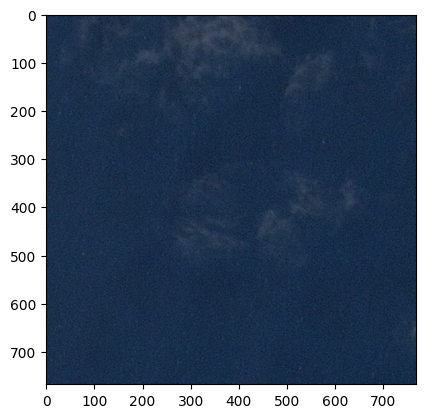

In [7]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
X[0].shape

In [6]:
masks_list = []

for mask_data in train_masks_data['EncodedPixels'][:300]:
    masks_list.append(convert_mask_data(mask_data))

y = np.array(masks_list)

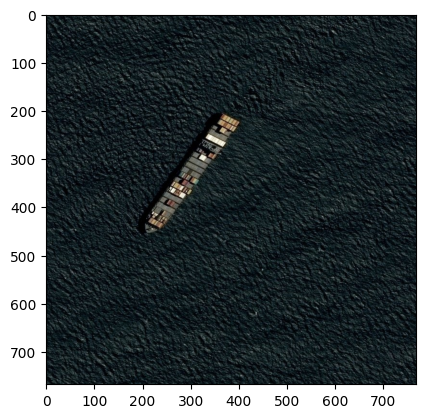

In [9]:
plt.imshow(cv2.cvtColor(X[17], cv2.COLOR_BGR2RGB))

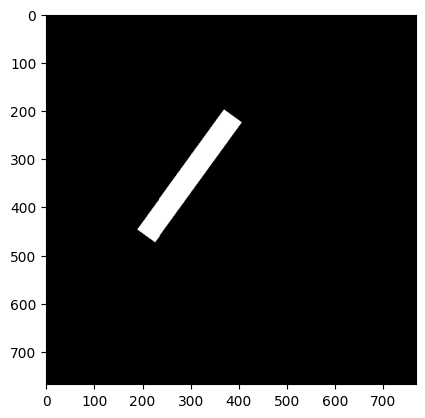

In [10]:
plt.imshow(cv2.cvtColor(y[17], cv2.COLOR_BGR2RGB))

In [7]:
def dice_score(original, predicted):
    doubled_intersection = 2 * np.sum(original * predicted)
    masks_sum = np.sum(original) + np.sum(predicted)
    score = doubled_intersection / masks_sum
    return score


def convolutional_block(filters_num, input_layer):
    conv = Conv2D(filters=filters_num, kernel_size=3, padding='same', activation='relu')(input_layer)
    conv = Conv2D(filters=filters_num, kernel_size=3, padding='same', activation='relu')(conv)
    return conv


def encoder(filters_num, input_layer):
    conv = convolutional_block(filters_num, input_layer)
    enc = MaxPool2D(pool_size=(2, 2))(conv)
    return conv, enc


def decoder(filters_num, current_input, prev_input):
    dec = UpSampling2D((2, 2))(current_input)
    conv = concatenate([dec, prev_input])
    conv = convolutional_block(filters_num, conv)
    return conv


inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv_1, enc_1 = encoder(64, inputs)
conv_2, enc_2 = encoder(128, enc_1)
middle = convolutional_block(256, enc_2)
dec_1 = decoder(128, middle, conv_2)
dec_2 = decoder(64, dec_1, conv_1)

outputs = Conv2D(3, 1, padding='same', activation='softmax')(dec_2)

unet_model = Model(inputs, outputs)
optimizer = keras.optimizers.Adam(lr=0.01)
unet_model.compile(optimizer=optimizer, loss='binary_crossentropy')
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 768, 768, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 768, 768, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 384, 384, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [8]:
X = X.astype("float32") / 255
y = y.astype("float32") / 255

print(X[81].shape)
print(y[81].shape)

(768, 768, 3)
(768, 768, 3)


In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
history = unet_model.fit(train_X, train_y, batch_size=2, epochs=2)

Epoch 1/2
120/120 [==============================] - 103s 601ms/step - loss: 0.0544
Epoch 2/2
120/120 [==============================] - 78s 652ms/step - loss: 0.0111


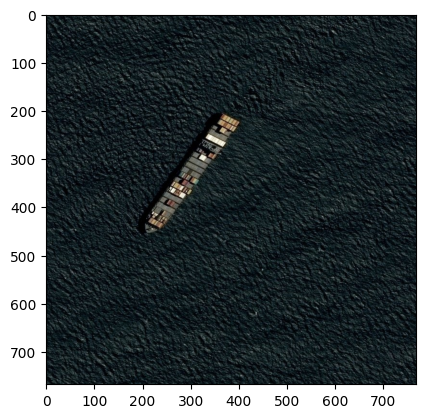

In [11]:
plt.imshow(cv2.cvtColor(test_X[30], cv2.COLOR_BGR2RGB))

In [12]:
pred = unet_model.predict(np.expand_dims(test_X[30], axis=0))

1/1 [==============================] - 4s 4s/step


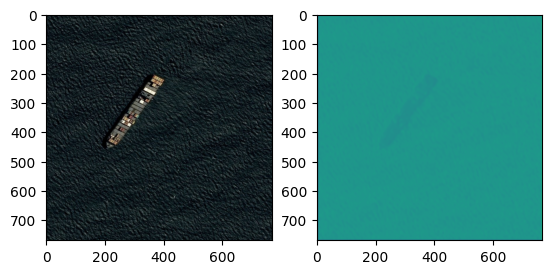

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_X[30], cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(pred[0], cv2.COLOR_BGR2GRAY))

In [19]:
print(dice_score(test_y[30], pred[0]))

0.04441660186805929
